In [2]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib.axes as axe
import pandas as pd
import datetime as dt
import gurobipy as gp
from gurobipy import GRB
import cvxpy as cp

import random
from itertools import chain, combinations, tee
import time

plt.rcParams['text.usetex'] = True
# plt.rcParams['text.usetex'] = False

# Budget vs Discount - Theory

## Discount: 1 Eligible group, continuum of evenly spaced Ineligible groups

In [30]:
def F(val, ell, tau, v, alpha):
    return ell(val) + (1 - alpha) * tau / v - ell(2 - val)

def y_star(ell, tau, v, alpha = 0.0, lb_init = 0.0, ub_init = 1.0, num_iters = 20):
    # Searches for y^\star satisfying ell(y^\star) + (1 - \alpha) \tau/v = ell(1 - y^\star)
    assert tau < ell(ub_init) - ell(lb_init), "We must have tau < ell(1.0) - ell(0.0), else is trivial"
    assert 0.0 <= alpha <= 1.0, "We must have 0.0 <= alpha <= 1.0"
    assert ell(lb_init) + (1.0 - alpha) * tau / v < ell(ub_init)
    
    lb = lb_init
    ub = ub_init
    mid_val = (lb + ub)/2
    
    for k in range(num_iters):
#         print("F:", F(mid_val, ell, tau, alpha))
#         print("lb:", lb)
#         print("ub:", ub)
#         print("mid_val:", mid_val)
#         print()
        
        if F(mid_val, ell, tau, v, alpha) < 0:
            lb = mid_val
        else:
            ub = mid_val
        mid_val = (lb + ub)/2
    
    return (lb + ub)/2

def yD_from_v(v_all_array, ell, tau):
    assert v_all_array_sorted.shape[0] <= 2, "there must be more than 0 bins for the eligible users, \
        and more than 1 bin for the ineligible users"
     
    v_all_array_sorted = v_all_array[v_all_array[:, 0].argsort()]
    v_index_lb = 0
    v_index_ub = v_all_array_sorted.shape[0]
    v_index_mid = int(v_all_array_sorted.shape[0]/2)
    
    while v_index_ub > v_index_lb + 1:
        v_index_mid = int((v_index_ub + v_index_lb)/2)
        v_current = v_all_array_sorted[v_index_mid, 0]
#         y_star_current = y_star(ell, tau, v_current, alpha = 0.0)

        y_current = v_all_array_sorted[v_index_mid:, 1:]
        if ell(y_current) + v_current >= ell(2 - y_current):
            v_index_lb = v_index_mid
        else:
            v_index_ub = v_index_mid

        ## TODO: INCOMPLETE
    
    return 


In [29]:
a = np.block([[np.arange(10)], [np.ones(10)]]).T
index = 5

print("a:\n", a)
print()
print("a[0:index, 0:2]:\n\n", a[index:, 0:])
print()
print("sum(a[0:index, 0]):", sum(a[0:index, 0]))

a:
 [[0. 1.]
 [1. 1.]
 [2. 1.]
 [3. 1.]
 [4. 1.]
 [5. 1.]
 [6. 1.]
 [7. 1.]
 [8. 1.]
 [9. 1.]]

a[0:index, 0:2]:

 [[5. 1.]
 [6. 1.]
 [7. 1.]
 [8. 1.]
 [9. 1.]]

sum(a[0:index, 0]): 10.0


In [ ]:
# arr_temp = np.array([[1, 0.1], [3, 0.15], [2, 0.2], [4, 0.12]])
# arr_temp[arr_temp[:, 0].argsort()]
# max(arr_temp)

In [1]:
t_1 = time.time()

ell = lambda x: x**4 / 16
# ell = lambda x: np.log(1 + np.exp(x))
# alpha = 0.0

# # Case 1: 
# tau = 0.4
# v_E = 1
# v_I = 1.25

# # Case 2: 
# tau = 0.7
# v_E = 1
# v_I = 1.25

# Case 3: 
tau = 0.7
v_E = 1
v_I = 2.5

# Continuum for ineligible users' VoTs (centered at v_I):
beta = 0.5
N_v_grid = 99
assert 0.0 <= beta <= 1.0, "beta should be between 0.0 and 1.0"
v_I_array = np.zeros((N_v_grid, 2))
v_I_array[:, 1] = 1/N_v_grid
v_I_start = (1 - beta) * v_I + (1/(N_v_grid + 1)) * 2 * beta * v_I
v_I_end = (1 + beta) * v_I - (1/(N_v_grid + 1)) * 2 * beta * v_I
v_I_array[:, 0] = np.linspace(v_I_start, v_I_end, N_v_grid)
# print(v_I_array)

v_all_array_setup = np.block([v_I_array, np.zeros((N_v_grid, 1))])

# assert 0.0 > 1.0

# Compute yD curve.

num_alpha_grid_points = 500 # Should be even
alpha_vals = list(np.linspace(0, 1.0, num = num_alpha_grid_points + 1))

## To edit, below:

for alpha_index in alpha_val in enumerate(alpha_vals):
    if alpha_val >= 1.0:
        # Note: May change if total eligible flow != 1.0 or total ineligible flow != 1.0
        y_D = 1.0
    elif v_E/(1 - alpha_val) > (1 + beta) * v_I:
        # Note: May change if total eligible flow != 1.0 or total ineligible flow != 1.0
        y_D = y_star(ell, tau, v = v_E, alpha = alpha_val)
    elif v_E/(1 - alpha_val) < (1 - beta) * v_I:
        # Note: May change if total eligible flow != 1.0 or total ineligible flow != 1.0
        y_D = 0.0
    else:
        v_all_array = np.block([[v_all_array_setup], [v_E/(1 - alpha_val), 0.0, 1.0]])
        y_D, _ = yD_from_v(v_all_array, ell, tau)
        
        
        
# To delete below once the above is complete.
        
        

# y_star_zero = y_star(ell, tau, v_E, alpha = 0.0, lb_init = 0.0, ub_init = 2.0)
# # print("y_star_zero:", y_star_zero)

y_star_vals = np.array([y_star(ell, tau, v_E, alpha = alpha, lb_init = 0.0, ub_init = 2.0) for alpha in alpha_vals])
# for alpha in alpha_vals:
#     print("alpha:", alpha)
#     y_star_temp = y_star(ell, tau, v_E, alpha = alpha, lb_init = 0.0, ub_init = 2.0)

y_star_vals_budget = alpha_vals
index_max = max([k for k in list(range(num_alpha_grid_points)) if alpha_vals[k] <= 1 - v_E/v_I])
# print("index_min:", index_min)
# print("alpha_vals[index_min]:", alpha_vals[index_min])
# print("y_star_vals_budget:", y_star_vals_budget)
# print()

# print("y_star_vals:", y_star_vals)
# print()

y_star_vals_discount = np.copy(y_star_vals)
for k in range(y_star_vals_discount.shape[0]):
    if k <= index_max:
        y_star_vals_discount[k] = 0.0

tau_thresh_for_alpha_3 = 2 * v_E * (ell(1) - ell(1 - 1E-6)) / 1E-6
index_for_alpha_3 = max([k for k in list(range(num_alpha_grid_points)) if y_star_vals[k] >= alpha_vals[k] ])
alpha_3 = (y_star_vals[index_for_alpha_3] + y_star_vals[index_for_alpha_3 + 1])/2

# print("y_star_vals_budget:", y_star_vals_budget)

# print("y_star_vals_budget:", y_star_vals_budget)


t_2 = time.time()
print("Time:", t_2 - t_1)

NameError: name 'time' is not defined

In [22]:
# # type([1]) == float
# type(1.0) == float

Text(0, 0.5, '$\\displaystyle y^C, y^D$')

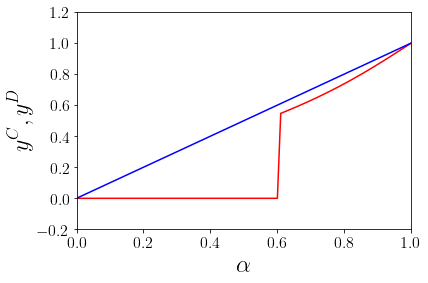

In [8]:
plt.plot(alpha_vals, y_star_vals_discount, 'red')
plt.plot(alpha_vals, y_star_vals_budget, 'blue')
# plt.scatter(alpha_vals, y_star_vals_discount, marker = 'o', s = 0.5, color = 'purple')
# plt.scatter(alpha_vals, y_star_vals_budget, marker = 'o', s = 0.5, color = 'black')
plt.xlim([0, 1.0])
plt.ylim([-0.2, 1.2])

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel(r'$\displaystyle \alpha$', fontsize=24)
plt.ylabel(r'$\displaystyle y^C, y^D$', fontsize=24)
# plt.ylabel(r'$\displaystyle \ln(L^t - L^\star)$', fontsize=16)

# Scratch Work - 1 Eligible group, 1 Ineligible group

In [10]:
def _extract_solution_discount_b1(m):
    """
    Get solution from optimization model
    """
    users_in = [v.x for v in m.getVars() if v.VarName.find("ineligible_val") != -1]
    users_el = [v.x for v in m.getVars() if v.VarName.find("eligible_allocation") != -1]
    edge_flows = [v.x for v in m.getVars() if v.VarName.find("edge_flows") != -1]
    
    users_in = np.reshape(users_in, (3, T))
    users_el = np.reshape(users_el, (3, T))
    edge_flows = np.reshape(edge_flows, (2, T))

    solution = {
        "users_in": users_in,
        "users_el": users_el,
        "edge_flows": edge_flows
    }
    
    return solution

In [11]:
def _extract_solution_discount_d1(m):
    """
    Get solution from optimization model
    """
    users_in = [v.x for v in m.getVars() if v.VarName.find("ineligible_val") != -1]
    users_el = [v.x for v in m.getVars() if v.VarName.find("eligible_allocation") != -1]
    edge_flows = [v.x for v in m.getVars() if v.VarName.find("edge_flows") != -1]
    
    users_in = np.reshape(users_in, (2, T))
    users_el = np.reshape(users_el, (2, T))
    edge_flows = np.reshape(edge_flows, (2, T))

    solution = {
        "users_in": users_in,
        "users_el": users_el,
        "edge_flows": edge_flows
    }
    
    return solution

In [12]:
def avg_travel_times_1(solution_set, theta):
    
    users_in = solution_set["users_in"]
    users_el = solution_set["users_el"]
    edge_flows = solution_set["edge_flows"]
    
    avg_travel_time_in = sum( users_in[j, t] * (theta[j,0] + edge_flows[j, t] * theta[j,1]) for j in range(2) for t in range(T)) / T
    avg_travel_time_el = sum( users_el[j, t] * (theta[j,0] + edge_flows[j, t] * theta[j,1]) for j in range(2) for t in range(T)) / T
    avg_travel_time_all = sum( edge_flows[j, t] * (theta[j,0] + edge_flows[j, t] * theta[j,1]) for j in range(2) for t in range(T)) / (T*2)
    
    avg_travel_times = {
        "users_in": avg_travel_time_in,
        "users_el": avg_travel_time_el,
        "users_all": avg_travel_time_all
    }
    
    return avg_travel_times

# def percentage_users()


In [13]:
def m_d1_solve(theta, T, toll, vot_ineligible, vot_eligible, discount_ratio):
    a_1 = theta[0, 0]
    b_1 = theta[0, 1]
    a_2 = theta[1, 0]
    b_2 = theta[1, 1]
    
    # Initialize model
    m_d1 = gp.Model()

    users_in = m_d1.addVars(2, T, name = 'ineligible_val', lb = -10000.0, ub = 10000.0)
    users_el = m_d1.addVars(2, T, name = 'eligible_allocation', lb = -10000.0, ub = 10000.0)
    edge_flows = m_d1.addVars(2, T, name = 'edge_flows', lb = -10000.0, ub = 10000.0)

    ## Add constraints to Model 

    # Total edge flow, express and general purpose lanes:
    m_d1.addConstrs((edge_flows[j, t] == users_in[j, t] + users_el[j, t] for j in range(2) for t in range(T)))

    # Non-negativity of flows, and zero flow for "eligible users in ineligible groups":
    m_d1.addConstrs((users_in[j, t]>=0 for j in range(2) for t in range(T)))
    m_d1.addConstrs((users_el[j, t]>=0 for j in range(2) for t in range(T)))

    # Every eligible and ineligible user is assigned to one of three options: \
    # (express paying, express with credit, non-express)
    m_d1.addConstrs((sum(users_in[j, t] for j in range(2)) == 1 for t in range(T)))
    m_d1.addConstrs((sum(users_el[j, t] for j in range(2)) == 1 for t in range(T)))

    ## To edit below:
    # Set Objective
    m_d1.setObjective(sum( a_1*edge_flows[0, t] + b_1*(edge_flows[0, t]**2)/2  
                        + a_2*edge_flows[1, t] + b_2*(edge_flows[1, t]**2)/2 
                        + toll*users_in[0,t]/vot_ineligible
                        + (1 - discount_ratio)*toll*users_el[0,t]/vot_eligible 
        for t in range(T)), GRB.MINIMIZE)
    
    m_d1.update()

    m_d1.optimize()
    
    solution_set_d1 = _extract_solution_discount_d1(m_d1)

    return solution_set_d1

In [14]:
def m_b1_solve(theta, T, toll, vot_ineligible, vot_eligible, budget):
    a_1 = theta[0, 0]
    b_1 = theta[0, 1]
    a_2 = theta[1, 0]
    b_2 = theta[1, 1]
    
    # Initialize model
    m_b1 = gp.Model()

    users_in = m_b1.addVars(3, T, name = 'ineligible_val', lb = -10000.0, ub = 10000.0)
    users_el = m_b1.addVars(3, T, name = 'eligible_allocation', lb = -10000.0, ub = 10000.0)
    edge_flows = m_b1.addVars(2, T, name = 'edge_flows', lb = -10000.0, ub = 10000.0)

    ## Add constraints to Model 

    # Total edge flow, express and general purpose lanes:
    m_b1.addConstrs((edge_flows[0, t] == users_in[0, t] + users_el[0, t] + users_in[1, t] + users_el[1, t] for t in range(T)))
    m_b1.addConstrs((edge_flows[1, t] == users_in[2, t] + users_el[2, t] for t in range(T)))

    # Non-negativity of flows, and zero flow for "eligible users in ineligible groups":
    m_b1.addConstrs((users_in[j, t] >= 0 for j in range(3) for t in range(T)))
    m_b1.addConstrs((users_el[j, t] >= 0 for j in range(3) for t in range(T)))
    m_b1.addConstrs((users_in[0, t] == 0 for t in range(T)))
    
    # Budget constraint satisfaction:
    if toll != 0:
        m_b1.addConstr((sum(toll*users_el[0, t] for t in range(T)) <= budget))
    m_b1.addConstrs((users_in[0, t] == 0 for t in range(T)))

    # Every eligible and ineligible user is assigned to one of three options: \
    # (express paying, express with credit, non-express)
    m_b1.addConstrs((sum(users_in[j, t] for j in range(3)) == 1 for t in range(T)))
    m_b1.addConstrs((sum(users_el[j, t] for j in range(3)) == 1 for t in range(T)))

    ## To edit below:
    # Set Objective
    m_b1.setObjective(sum( a_1 * (edge_flows[0, t]) + b_1 * (edge_flows[0, t]**2)/2  
                        + a_2 * (edge_flows[1, t]) + b_2 * (edge_flows[1, t]**2)/2 
                        + toll * users_in[1,t]/vot_ineligible
                        + toll * users_el[1,t]/vot_eligible
        for t in range(T)), GRB.MINIMIZE)
    
    m_b1.update()

    m_b1.optimize()
    
    solution_set_b1 = _extract_solution_discount_b1(m_b1)

    return solution_set_b1

In [ ]:
time_1 = time.time()

# Affine lane functions:
a_1 = 1.0
b_1 = 1.0
a_2 = 1.0
b_2 = 1.0

# a_1 = 0.5
# b_1 = 0.5
# a_2 = 0.5
# b_2 = 0.5

# a_1 = 4.0
# b_1 = 2.0
# a_2 = 5.0
# b_2 = 1.5

theta = np.array([[a_1, b_1], [a_2, b_2]])
T = 5
# toll = 1.0
# budget = 0.25
toll_array = (np.arange(20) + 1)/20
budget_array = (np.arange(20) + 1)*T/20

vot_ineligible = 1
vot_eligible = 1

solution_set_array_d1 = {}
solution_set_array_bpure_1 = {}
solution_set_array_b1 = {}

# Return solution:

for toll_idx, toll in enumerate(toll_array):
    
    solution_set_array_at_toll_d1 = {}
    solution_set_array_at_toll_bpure_1 = {}
    solution_set_array_at_toll_b1 = {}
    
    for budget_idx, budget in enumerate(budget_array):
        
        if budget > toll * T:
            continue
        
        discount_ratio = budget / (toll * T)
        
        print()
        print("Toll:", toll)
        print("Budget:", budget)
        print("Discount Ratio:", discount_ratio)
        print()
        
        solution_set_d1 = m_d1_solve(theta, T, toll, vot_ineligible, vot_eligible, discount_ratio)
        solution_set_bpure_1 = m_bpure_1_solve(theta, T, toll, vot_ineligible, vot_eligible, budget)
        solution_set_b1 = m_b1_solve(theta, T, toll, vot_ineligible, vot_eligible, budget)
        
        solution_set_array_at_toll_d1[budget] = solution_set_d1
        solution_set_array_at_toll_bpure_1[budget] = solution_set_bpure_1
        solution_set_array_at_toll_b1[budget] = solution_set_b1
    
    solution_set_array_d1[toll] = solution_set_array_at_toll_d1
    solution_set_array_bpure_1[toll] = solution_set_array_at_toll_bpure_1
    solution_set_array_b1[toll] = solution_set_array_at_toll_b1

time_2 = time.time()
print("Time: ", time_2 - time_1)

In [ ]:
# Average travel times, discount minus budget:

avg_travel_time_discount_minus_budget = np.zeros((toll_array.shape[0], budget_array.shape[0], 6))
# 0: in
# 1: el
# 2: all
# 3: in (pure)
# 4: el (pure)
# 5: all (pure)

for toll_idx, toll in enumerate(toll_array):    
    for budget_idx, budget in enumerate(budget_array):        
        if budget > toll * T:
            continue
            
#         print("toll:", toll)
#         print("budget:", budget)
#         print()

#         diff_in = avg_travel_times_1(solution_set_array_d1[toll][budget], theta)["users_in"] \
#             - avg_travel_times_1(solution_set_array_bpure_1[toll][budget], theta)["users_in"]
#         diff_el = avg_travel_times_1(solution_set_array_d1[toll][budget], theta)["users_el"] \
#             - avg_travel_times_1(solution_set_array_bpure_1[toll][budget], theta)["users_el"]
#         diff_all = avg_travel_times_1(solution_set_array_d1[toll][budget], theta)["users_all"] \
#             - avg_travel_times_1(solution_set_array_bpure_1[toll][budget], theta)["users_all"]

        diff_in = avg_travel_times_1(solution_set_array_d1[toll][budget], theta)["users_in"] \
            - avg_travel_times_1(solution_set_array_b1[toll][budget], theta)["users_in"]
        diff_el = avg_travel_times_1(solution_set_array_d1[toll][budget], theta)["users_el"] \
            - avg_travel_times_1(solution_set_array_b1[toll][budget], theta)["users_el"]
        diff_all = avg_travel_times_1(solution_set_array_d1[toll][budget], theta)["users_all"] \
            - avg_travel_times_1(solution_set_array_b1[toll][budget], theta)["users_all"]
        
        diff_in_pure = avg_travel_times_1(solution_set_array_d1[toll][budget], theta)["users_in"] \
            - avg_travel_times_1(solution_set_array_bpure_1[toll][budget], theta)["users_in"]
        diff_el_pure = avg_travel_times_1(solution_set_array_d1[toll][budget], theta)["users_el"] \
            - avg_travel_times_1(solution_set_array_bpure_1[toll][budget], theta)["users_el"]
        diff_all_pure = avg_travel_times_1(solution_set_array_d1[toll][budget], theta)["users_all"] \
            - avg_travel_times_1(solution_set_array_bpure_1[toll][budget], theta)["users_all"]
    
        avg_travel_time_discount_minus_budget[toll_idx][budget_idx][0] = diff_in
        avg_travel_time_discount_minus_budget[toll_idx][budget_idx][1] = diff_el
        avg_travel_time_discount_minus_budget[toll_idx][budget_idx][2] = diff_all
        
        avg_travel_time_discount_minus_budget[toll_idx][budget_idx][3] = diff_in_pure
        avg_travel_time_discount_minus_budget[toll_idx][budget_idx][4] = diff_el_pure
        avg_travel_time_discount_minus_budget[toll_idx][budget_idx][5] = diff_all_pure

# avg_travel_time_discount_minus_budget

In [ ]:
print("Users_in:")
print("Max average time difference, discount minus budget, value:", \
          np.max(avg_travel_time_discount_minus_budget[:, :, 0]))
print("Min average time difference, discount minus budget, value:", \
          np.min(avg_travel_time_discount_minus_budget[:, :, 0]))
print()

print("Users_el:")
print("Max average time difference, discount minus budget, value:", \
          np.max(avg_travel_time_discount_minus_budget[:, :, 1]))
print("Min average time difference, discount minus budget, value:", \
          np.min(avg_travel_time_discount_minus_budget[:, :, 1]))
print()

print("Users_all:")
print("Max average time difference, discount minus budget, value:", \
          np.max(avg_travel_time_discount_minus_budget[:, :, 2]))
print("Min average time difference, discount minus budget, value:", \
          np.min(avg_travel_time_discount_minus_budget[:, :, 2]))
print()
print()

print("Users_in (pure):")
print("Max average time difference, discount minus budget, value:", \
          np.max(avg_travel_time_discount_minus_budget[:, :, 3]))
print("Min average time difference, discount minus budget, value:", \
          np.min(avg_travel_time_discount_minus_budget[:, :, 3]))
print()

print("Users_el (pure):")
print("Max average time difference, discount minus budget, value:", \
          np.max(avg_travel_time_discount_minus_budget[:, :, 4]))
print("Min average time difference, discount minus budget, value:", \
          np.min(avg_travel_time_discount_minus_budget[:, :, 4]))
print()

print("Users_all (pure):")
print("Max average time difference, discount minus budget, value:", \
          np.max(avg_travel_time_discount_minus_budget[:, :, 5]))
print("Min average time difference, discount minus budget, value:", \
          np.min(avg_travel_time_discount_minus_budget[:, :, 5]))

In [ ]:
# avg_travel_time_discount_minus_budget[:, :, 2]

In [ ]:
# edge_flows_d1 = solution_set_d1["edge_flows"]
# users_el_d1 = solution_set_d1["users_el"]
# users_in_d1 = solution_set_d1["users_in"]

# edge_flows_bpure_1 = solution_set_bpure_1["edge_flows"]
# users_el_bpure_1 = solution_set_bpure_1["users_el"]
# users_in_bpure_1 = solution_set_bpure_1["users_in"]

# print("edge_flows_d1:\n", edge_flows_d1)
# print()
# print("users_el_d1:\n", users_el_d1)
# print()
# print("users_in_d1:\n", users_in_d1)
# print()

# print()
# print("edge_flows_bpure_1:\n", edge_flows_bpure_1)
# print()
# print("users_el_bpure_1:\n", users_el_bpure_1)
# print()
# print("users_in_bpure_1:\n", users_in_bpure_1)
# print()

# avg_travel_times_d1 = avg_travel_times_1(solution_set_d1, theta)
# avg_travel_times_bpure_1 = avg_travel_times_1(solution_set_bpure_1, theta)

# print()
# print("avg_travel_times_d1:\n", avg_travel_times_d1)
# print()
# print("avg_travel_times_bpure_1:\n", avg_travel_times_bpure_1)
# print()

# From other files:

In [ ]:
# # Solver 2, Discount:

# def OptPL_discount(toll, discount_ratio, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible, 
#             vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, 
#               fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity, c_2 = bpr_true_capacity, 
#              a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope, b_2 = apx_slope):
#     """
#     Function to solve convex optimization problem given a particular toll and budget value
#     """
    
#     # Initialize model
#     m1 = gp.Model()
#     # Add variables to model
# #     users_in = m1.addVars(num_ineligible, 3, T, name = 'ineligible_val', lb = 0.0, ub = 2.0)
# #     edge_flows = m1.addVars(2, T, name = 'edge_flows', lb = 0.0, ub = num_ineligible * 2.0)
# #     users_el = m1.addVars(3, T, name = 'eligible_allocation', lb = 0.0, ub = 2.0)
#     # Add variables for piecewise affine approximation
# #     eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = 0.0, ub = num_ineligible * 2.0)
    
# #     # Add variables for piecewise affine approximation
# #     eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = 0.0, ub = num_ineligible * 2.0)
#     users_in = m1.addVars(num_ineligible, 2, T, name = 'ineligible_val', lb = -10000.0, ub = 10000.0)
#     edge_flows = m1.addVars(2, T, name = 'edge_flows', lb = -10000.0, ub = 10000.0)
#     users_el = m1.addVars(2, T, name = 'eligible_allocation', lb = -10000.0, ub = 10000.0)
#     eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = -10000.0, ub = 10000.0)   

#     ## Add constraints to Model 
    
#     # Total edge flow, express and general purpose lanes:
#     m1.addConstrs((edge_flows[j, t] == sum(users_in[i, j, t] for i in range(num_ineligible)) + \
#                   users_el[j, t] for j in range(2) for t in range(T)))
    
#     # Non-negativity of flows, and zero flow for "eligible users in ineligible groups":
#     m1.addConstrs((users_in[i, j, t]>=0 for i in range(num_ineligible) for j in range(2) for t in range(T)))
#     m1.addConstrs((users_el[j, t]>=0 for j in range(2) for t in range(T)))
    
#     # Every eligible and ineligible user is assigned to one of three options: \
#     # (express paying, express with credit, non-express)
#     m1.addConstrs((sum(users_in[i, j, t] for j in range(2)) == 1 for i in range(num_ineligible) for t in range(T)))
#     m1.addConstrs((sum(users_el[j, t] for j in range(2)) == num_eligible for t in range(T)))
        
#     # Piecewise affine approximation:
#     m1.addConstrs((eps_flows[j, t] >= 0 for j in range(2) for t in range(T))) # Must be at least 0
#     m1.addConstrs((eps_flows[0, t] >= edge_flows[0, t] - cap_thresh*c_1 for t in range(T))) # Must be at least flow - capacity
#     m1.addConstrs((eps_flows[1, t] >= edge_flows[1, t] - cap_thresh*c_2 for t in range(T))) # Must be at least flow - capacity
    
    
#     ## To edit below:
#     # Set Objective
#     m1.setObjective(sum( a*fftt_1*(edge_flows[0, t]) + b_1*(eps_flows[0, t]**2)/2  
#                         + a*fftt_2*(edge_flows[1, t]) + b_2*(eps_flows[1, t]**2)/2 
#                         + sum( toll*users_in[i,0,t]/vot_ineligible[i,t] for i in range(num_ineligible))
#                         + sum( (1 - discount_ratio)*toll*users_el[0,t]/vot_eligible[i,t] for i in range(num_eligible))
#         for t in range(T)), GRB.MINIMIZE)
    
#     m1.update()
    
#     return m1

# Scratch Work:

In [ ]:
# m_sample = gp.Model()


# Plotting code (Old, fill_between):

In [ ]:
# x = np.arange(0.0, 2, 0.01)
# y1 = np.sin(2 * np.pi * x)
# y2 = 0.8 * np.sin(4 * np.pi * x)

# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(6, 6))

# ax1.fill_between(x, y1)
# ax1.set_title('fill between y1 and 0')

In [ ]:
# _, ax = plt.subplots()

# plt.plot(alpha_vals, y_star_vals_discount, 'r')
# plt.plot(alpha_vals, y_star_vals_budget, 'k')
# plt.plot(alpha_vals, alpha_vals, 'k')
# plt.xlim([0, 1])
# plt.ylim([0, 1.2])
# # axe.Axes.fill_between(alpha_vals, y_star_vals_budget, y_star_vals_discount)
# # axe.Axes.fill_between(alpha_vals, y_star_vals_budget, 1)
# ax.fill_between(alpha_vals, y_star_vals_budget, alpha_vals, color = 'k')